In [14]:
import random
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

In [15]:
from math import floor
from itertools import combinations
from collections import defaultdict
from networkx import NetworkXException
from networkx.algorithms.approximation import steiner_tree

<div class="alert alert-block alert-info">
<b>🌌Graph:</b> fidelity-aware distribution of a 3-qubit GHZ state
using site-bond percolation to model the underlying quantum network.
</div>

_Initialize the Graph_

In [16]:
def build_initial_grid(w, h):
    G = nx.Graph()
    for i in range(w):
        for j in range(h):
            G.add_node((i, j))
            parity = (i + j) % 2
            '''
            CHANGE: since the edges do not have direction, we can
            add edges only in the +1 direction.

            # ORIGINAL:
            for dx in [-1, 1]:
                ni = i + dx
                if 0 <= ni < w:
                    G.add_edge((i, j), (ni, j))
            '''
            # NEW:
            ni = i + 1
            if 0 <= ni < w:
                G.add_edge((i, j), (ni, j))

            if parity == 0 and j + 1 < h:
                G.add_edge((i, j), (i, j + 1))
            elif parity == 1 and j - 1 >= 0:
                G.add_edge((i, j), (i, j - 1))
    return G

_site-bond percolation_

In [17]:
def percolate_graph(G, w, h, p, q, p_f, terminals):
    Gp = G.copy()
    # Bond
    for edge in list(Gp.edges):
        if random.random() > p:
            Gp.remove_edge(*edge)
        else:
            if random.random() < p_f:
                Gp.edges[edge]['fidelity'] = 1.0
            else:
                Gp.edges[edge]['fidelity'] = random.uniform(0.9, 1.0)

    '''
    CHANGE: instead of returning first connected component,
    return that with the highest average fidelity of the edges.

    # ORIGINAL:
    # Site
    for component in nx.connected_components(Gp):
        if terminals <= component:
            surviving_nodes = set()
            for node in component:
                if node in terminals or random.random() <= q:
                    surviving_nodes.add(node)
            return Gp.subgraph(surviving_nodes).copy()
    '''
    # NEW:
    # Site
    components_with_terminals = []
    for component in nx.connected_components(Gp):
        if terminals <= component:
            surviving_nodes = set()
            for node in component:
                if node in terminals or random.random() <= q:
                    surviving_nodes.add(node)
            candidate_component = Gp.subgraph(surviving_nodes).copy()

            fidelities = [candidate_component.edges[edge]['fidelity'] for edge in list(candidate_component.edges)]
            average_fidelity = sum(fidelities) / len(fidelities)
            components_with_terminals.append((candidate_component, average_fidelity))

    if len(components_with_terminals) > 0:
        best_component, best_average_fidelity = max(components_with_terminals, key = lambda x: x[1])
        return best_component
    else:
        return None
# ---------------------------------------------------------------------------------------------------------
# calculate the tree
def compute_steiner_tree(G, terminals, weight='fidelity'):
    comp = nx.node_connected_component(G, next(iter(terminals)))
    if terminals <= comp:
        return steiner_tree(G.subgraph(comp).copy(), terminals, weight=weight, method="kou")
    return None

_fidelity of the chain_

In [18]:
def compute_fidelity_along_path(G, path):
    fidelity = G[path[0]][path[1]].get("fidelity", 1.0)
    for i in range(1, len(path) - 1):
        f_next = G[path[i]][path[i + 1]].get("fidelity", 1.0)
        fidelity = fidelity * f_next + ((1 - fidelity) * (1 - f_next)) / 3
    return fidelity

def analyze_steiner_tree_fidelity(Gp, T, terminals):
    '''
    CHANGE: select the center node by the node yielding the
    highest average fidelity to the other terminals.

    # ORIGINAL:
    candidates = [n for n in T if T.degree[n] == max(dict(T.degree()).values())]
    center = next((n for n in candidates if n in terminals), candidates[0])
    '''
    # NEW:
    candidate_centers = []
    best_center = None
    for i in terminals:
        total_fidelity = 0
        reachable_nodes = 0
        for j in terminals:
            if i == j or not nx.has_path(T, i, j):
                continue
            path = nx.shortest_path(T, i, j)
            fidelity = compute_fidelity_along_path(Gp, path)
            total_fidelity += fidelity
            reachable_nodes += 1
        average_fidelity = total_fidelity / reachable_nodes
        candidate_centers.append((i, average_fidelity))
    best_center, best_average_fidelity = max(candidate_centers, key = lambda x: x[1])

    center = best_center
    # center = random.choice(list(terminals))
    print(f"Center node: {center}")
    fidelity_dict = {}
    for terminal in terminals:
        if terminal != center:
            path = nx.shortest_path(T, center, terminal)
            fidelity = compute_fidelity_along_path(Gp, path)
            fidelity_dict[terminal] = fidelity
        else:
            fidelity_dict[center] = 1.0
    return fidelity_dict
# ---------------------------------------------------------------------------------------------------------
# final fidelity
def compute_final_fidelity(F1, F2, F3):
    eps1 = (1 - F1) / 3
    eps2 = (1 - F2) / 3
    eps3 = (1 - F3) / 3
    e1 = eps1 + eps2 + eps3
    e2 = eps1 * eps2 + eps1 * eps3 + eps2 * eps3
    e3 = eps1 * eps2 * eps3
    F4 = 1 - 3 * e1 + 10 * e2 - 32 * e3
    return F4

📉_Visualize_

In [19]:
def visualize_parity_grid_with_abc(G, w, h, T=None, scale=0.8):
    pos = { (i, j): (scale * i, -scale * j) for (i, j) in G.nodes }

    A = (1, 1)
    B = (w - 2, h - 2)
    C = (w - 2, 1)

    terminals = {A, B, C}
    special_nodes = [n for n in terminals if n in G]
    regular_nodes = [n for n in G.nodes if n not in special_nodes]

    fig, ax = plt.subplots(figsize=(5, 5), constrained_layout=True)

    # Draw regular nodes
    nx.draw_networkx_nodes(G, pos, nodelist=regular_nodes, node_color='#4F8FC0', node_size=100, ax=ax)

    # Draw special nodes with different colors
    if A in G:
        nx.draw_networkx_nodes(G, pos, nodelist=[A], node_color='#62A87C', node_size=200, ax=ax)
    if B in G:
        nx.draw_networkx_nodes(G, pos, nodelist=[B], node_color='#7EE081', node_size=200, ax=ax)
    if C in G:
        nx.draw_networkx_nodes(G, pos, nodelist=[C], node_color='#C3F3C0', node_size=200, ax=ax)

    # Draw base graph edges
    nx.draw_networkx_edges(G, pos, edge_color='gray', width=1.0, ax=ax)

    # Draw Steiner tree if provided
    if T is not None and len(T.edges) > 0:
        nx.draw_networkx_edges(T, pos, edge_color='black', width=2.5, ax=ax)

    # Add labels for A, B, C if present
    labels = {n: lbl for n, lbl in zip([A, B, C], ['A', 'B', 'C']) if n in G}
    nx.draw_networkx_labels(G, pos, labels=labels, font_size=10, font_color='black', ax=ax)

    ax.set_title("Parity Grid with A, B, C + Steiner Tree")
    ax.axis('off')
    plt.show()

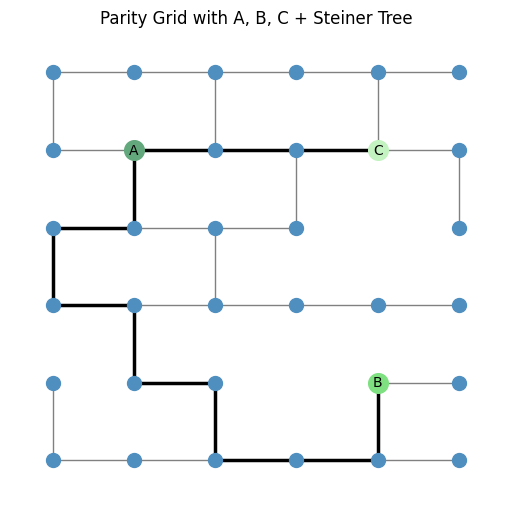

Center node: (1, 1)
fidelity dictionary: {(4, 4): 0.9158753281265356, (1, 1): 1.0, (4, 1): 1.0}
Final GHZ fidelity is: 0.9158753281265356


In [20]:
'''
CHANGE: set a random seed to allow for reproducibility.
'''
# NEW
random.seed(42)

p = 0.90
q = 0.95
p_f = 0.80
w = 6
h = 6
A = (1, 1)
B = (w - 2, h - 2)
C = (w - 2, 1)
terminals = {A, B, C}
# ---------------------------------------------------------------------------------------------------------
G = build_initial_grid(w, h)
Gp = percolate_graph(G, w, h, p, q, p_f, terminals)
T = compute_steiner_tree(Gp, terminals)
visualize_parity_grid_with_abc(Gp, w, h, T=T)
if T != None:
    fidelity_dict = analyze_steiner_tree_fidelity(Gp, T, terminals)
    F_vals = [fidelity_dict[t] for t in terminals]
    fidelity_ghz = compute_final_fidelity(*F_vals)
    print(f"fidelity dictionary: {fidelity_dict}")
    print(f"Final GHZ fidelity is: {fidelity_ghz}")
else:
    print("❌ No valid Steiner tree exists.")

<div class="alert alert-block alert-info">
<b>📡Hypergraph:</b> fidelity-aware distribution of a 3-qubit GHZ state
using site-bond percolation to model the underlying quantum network.
</div>

_Initialize the Hypergraph_

In [21]:
def build_hypergraph(w, h):
    G1 = build_initial_grid(w, h)
# ---------------------------------------------------------------------------------------------------------
    # potential bug: unwanted nodes are added at parity check
    G2 = nx.Graph()
    for i in range(w):
        for j in range(h):
            parity = (i + j) % 2
            if parity == 1: # parity 1 are the base nodes
                G2.add_node((i, j))
                if j + 1 < h and i + 2 < w:
                    G2.add_edge((i + 1, j), (i, j))
                    G2.add_edge((i + 1, j), (i + 1, j + 1))
                    G2.add_edge((i + 1, j), (i + 2, j))

    hyperg = [G1, G2]
    return hyperg

_Multiplex hypergraph Percolation_

In [22]:
def percolate_graph(hyperg, w, h, p, q, p_f, terminals):
    G1 = hyperg[0].copy()
    G2 = hyperg[1].copy()
    # ---------------------------------------------------------------------------------------------------------
    # Bond
    for edge in list(G1.edges):
        if random.random() > p:
            G1.remove_edge(*edge)
        else:
            if random.random() < p_f:
                G1.edges[edge]['fidelity'] = 1.0
            else:
                G1.edges[edge]['fidelity'] = random.uniform(0.9, 1.0)
    # ---------------------------------------------------------------------------------------------------------
    # Hyperedge
    factor_nodes = set()
    for node in list(G2.nodes):
            i, j = node
            if (i + j) % 2 == 0: # parity zero are hyperedges
                factor_nodes.add(node) # list of factor nodes
                if random.random() > p:
                    G2.remove_node(node)
                else:
                    if random.random() < p_f:
                        G2.nodes[node]['fidelity'] = 1.0
                    else:
                        G2.nodes[node]['fidelity'] = random.uniform(0.9, 1.0)
    # ---------------------------------------------------------------------------------------------------------
    '''
    CHANGE: instead of returning first connected component,
    return that with the highest average fidelity of the edges.

    # ORIGINAL:
    # Site
    for component in nx.connected_components(G1):
        if terminals <= component:
            survived1 = set()
            for node in component:
                if node in terminals or random.random() <= q:
                    survived1.add(node)

            survived2 = set(G2.nodes) & (survived1 | factor_nodes)
            result = [G1.subgraph(survived1).copy(), G2.subgraph(survived2).copy(), factor_nodes]
            return result
    return None
    '''
    # NEW:
    components_with_terminals = []
    for component in nx.connected_components(G1):
        if terminals <= component:
            surviving_nodes = set()
            for node in component:
                if node in terminals or random.random() <= q:
                    surviving_nodes.add(node)
            candidate_component = Gp.subgraph(surviving_nodes).copy()

            fidelities = [candidate_component.edges[edge]['fidelity'] for edge in list(candidate_component.edges)]
            average_fidelity = sum(fidelities) / len(fidelities)

            survived2 = set(G2.nodes) & (surviving_nodes | factor_nodes)
            components_with_terminals.append(([candidate_component, G2.subgraph(survived2).copy(), factor_nodes], average_fidelity))

    if len(components_with_terminals) > 0:
        best_component, best_average_fidelity = max(components_with_terminals, key = lambda x: x[1])
        return best_component
    else:
        return None

# ---------------------------------------------------------------------------------------------------------


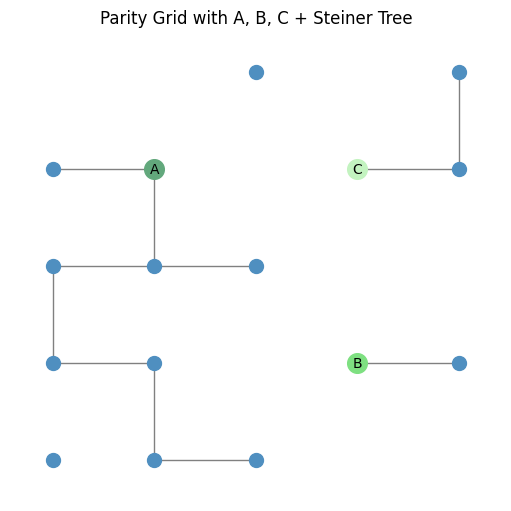

In [23]:
p = 0.80
q = 0.90
p_f = 0.80
w = 5
h = 5
A = (1, 1)
B = (w - 2, h - 2)
C = (w - 2, 1)
terminals = {A, B, C}
# ---------------------------------------------------------------------------------------------------------
hyperg = build_hypergraph(w, h)
per_hyperg = percolate_graph(hyperg, w, h, p, q, p_f, terminals)
# ---------------------------------------------------------------------------------------------------------
if per_hyperg != None:
    visualize_parity_grid_with_abc(per_hyperg[0], w, h)
else:
    print("❌ Does not include terminals.")

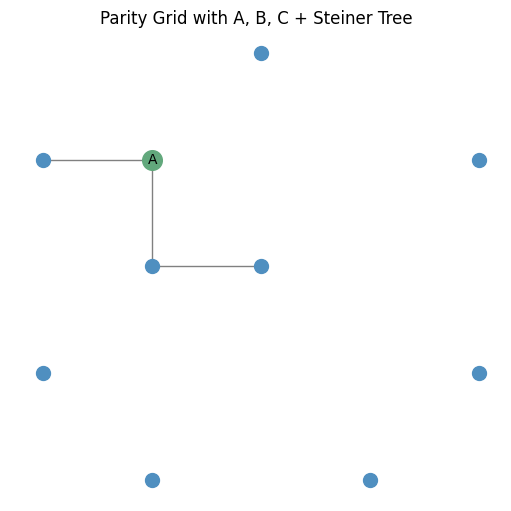

In [24]:
visualize_parity_grid_with_abc(per_hyperg[1], w, h)

In [25]:
def plot_hypergraph_components(hypergraph, w, h):
    decomposed_graph = decompose_edges_by_len(hypergraph)
    decomposed_edges = decomposed_graph['edges']
    base_nodes = decomposed_graph['nodes']
    n_edge_lengths = len(decomposed_edges)

    fig, axs = plt.subplots(1, n_edge_lengths, figsize=(5 * n_edge_lengths, 5))
    axs = np.atleast_1d(axs)
    for ax in axs:
        ax.axis('off')
    fig.patch.set_facecolor('#003049')

    for i, edge_order in enumerate(sorted(decomposed_edges)):
        edges = decomposed_edges[edge_order]
        g = nx.DiGraph()
        factor_nodes = []

        g.add_nodes_from(base_nodes)

        if edge_order == 2:
            g.add_edges_from(edges)
        else:
            for edge in edges:
                factor_node = (floor(sum(i for (i, j) in edge) / edge_order),
                                  floor(sum(j for (i, j) in edge) / edge_order))
                factor_nodes.append(factor_node)
                g.add_node(factor_node)
                for node in edge:
                    g.add_edge(node, factor_node)

        def grid_layout(w, h):
            return {(i, j): (i, -j) for i in range(w) for j in range(h)}

        pos = grid_layout(w, h)
        nx.draw_networkx_nodes(g, pos, nodelist=base_nodes, node_size=150,
                               ax=axs[i], node_color='#f77f00', label='True Nodes')
        nx.draw_networkx_nodes(g, pos, nodelist=factor_nodes, node_size=300,
                               ax=axs[i], node_color='#d62828', label='Factor Nodes')
        nx.draw_networkx_edges(g, pos, ax=axs[i], edge_color='#eae2b7',
                               connectionstyle='arc3,rad=0.05', arrowstyle='-')
        # labels = {node: str(node) for node in base_nodes}
        # nx.draw_networkx_labels(g, pos, labels, ax=axs[i])
    plt.tight_layout()
    plt.show()

In [26]:
w = 6
h = 6
build_hypergraph(w, h)
plot_hypergraph_components(build_hypergraph(w, h), w, h)

NameError: name 'decompose_edges_by_len' is not defined